In [1]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
import os.path
import copy
import cv2 as cv

# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
# On a 30 * 30 abdomens + 20 * 30 labelisés au total
RELOAD_DATA = False
nb_dirs_to_load = 1000 # 50 folders total, bigger number means load all
nb_files_to_load_per_dir = 5 # putting a number bigger than the number of files will just load every file in the folder

# if true, retrain model
DO_WE_LEARN = False
epochs = 20
file_name = "model_simple_3D.hdf5"

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

d:\GitHub\abdomen_segmentation\single_organ_segmentation


In [2]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for j in range(1):
        patient = img[j]
        for i in range(45, 100, 10):
            disp_list.append(patient[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -100, 100)

In [3]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    raw_patient = []
    labeled_patient = []
    labeled_scan = np.where(labeled_scan == 6, 1, 0).astype('uint8')
    for i in range(scan.shape[2]):
        if labeled_scan[:, :, i].sum() == 0:
            continue
        
        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)

        raw_patient.append(resized_data)
        labeled_patient.append(resized_data_labeled)

    raw_patient = np.array(raw_patient)
    labeled_patient = np.array(labeled_patient)

    # now fill or crop arrays until size 96 (necessary to reduce datasize and avoid OOM errors)
    s, sx, sy, sz = raw_patient.shape
    if s < 96:
        pair = False
        while(raw_patient.shape[0] < 96):
            if pair:
                raw_patient = np.append(raw_patient, np.zeros((1, sx, sy, sz)), axis=0)
                labeled_patient = np.append(labeled_patient, np.zeros((1, sx, sy, sz)), axis=0)
            else:
                raw_patient = np.insert(raw_patient, 0, np.zeros((1, sx, sy, sz)), axis=0)
                labeled_patient = np.insert(labeled_patient, 0, np.zeros((1, sx, sy, sz)), axis=0)
            pair = not pair
    elif s > 96:
        diff = s - 96
        left_half_diff = diff//2
        right_half_diff = diff - left_half_diff
        raw_patient = raw_patient[left_half_diff:(s - right_half_diff), :, :, :]
        labeled_patient = labeled_patient[left_half_diff:(s - right_half_diff), :, :, :]

    raw_data.append(raw_patient)
    labeled_data.append(labeled_patient)

unique : [-5.9728785 -5.9681253 -5.9617662 ...  6.442156   6.4587812  6.467688 ]
Data shape  : (150, 96, 160, 112, 1)
Label shape : (150, 96, 160, 112, 1)
Raw data type     : float32
Labeled data type : uint8


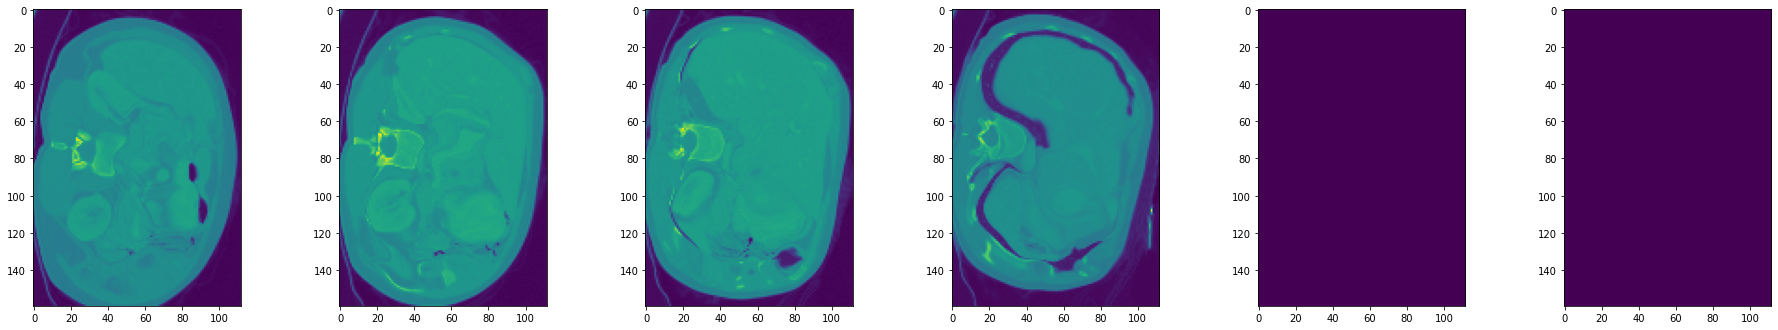

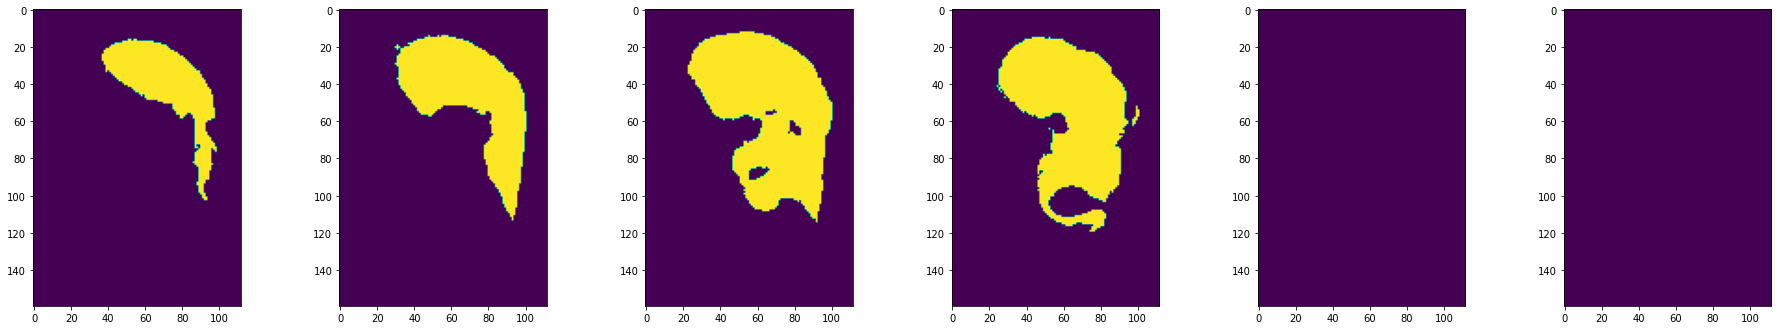

In [4]:
if RELOAD_DATA:
    loaded_dirs = 0
    for _, dirs, filenames in os.walk("../data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("../data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "../data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "../data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("../numpy_arrays/raw_liver_data_3D.npy", raw_data)
    np.save("../numpy_arrays/labeled_liver_data_3D.npy", labeled_data)
else:
    raw_data = np.load("../numpy_arrays/raw_liver_data_3D.npy")
    labeled_data = np.load("../numpy_arrays/labeled_liver_data_3D.npy")

raw_data = np.expand_dims(raw_data[:, :, :, :, 0], axis=4)
print(f"unique : {np.unique(raw_data)}")
print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print_slices(raw_data)
print_slices(labeled_data)

In [5]:
# ---- 3D UNET ----

_, sx, sy, sz, sk = raw_data.shape

nbf64 = 4
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet(input_size = (sx, sy, sz, 1)):
    inputs = Input(input_size)
    conv1 = Conv3D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv3D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling3D(pool_size = (2, 2, 2))(conv1)
    conv2 = Conv3D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv3D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling3D(pool_size = (2, 2, 2))(conv2)
    conv3 = Conv3D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv3D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling3D(pool_size = (2, 2, 2))(conv3)
    conv4 = Conv3D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv3D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size = (2, 2, 2))(conv4)

    conv5 = Conv3D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv3D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 4)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 4)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 4)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 4)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model = unet(input_size = (sx, sy, sz, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 160, 11  0           []                               
                                2, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 96, 160, 112  112         ['input_1[0][0]']                
                                , 4)                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 96, 160, 112  436         ['conv3d[0][0]']                 
                                , 4)                                                          

xtrain shape      : (120, 96, 160, 112, 1)
ytrain shape      : (120, 96, 160, 112, 1)
xvalidation shape : (15, 96, 160, 112, 1)
yvalidation shape : (15, 96, 160, 112, 1)
xtest shape       : (15, 96, 160, 112, 1)
ytest shape       : (15, 96, 160, 112, 1)


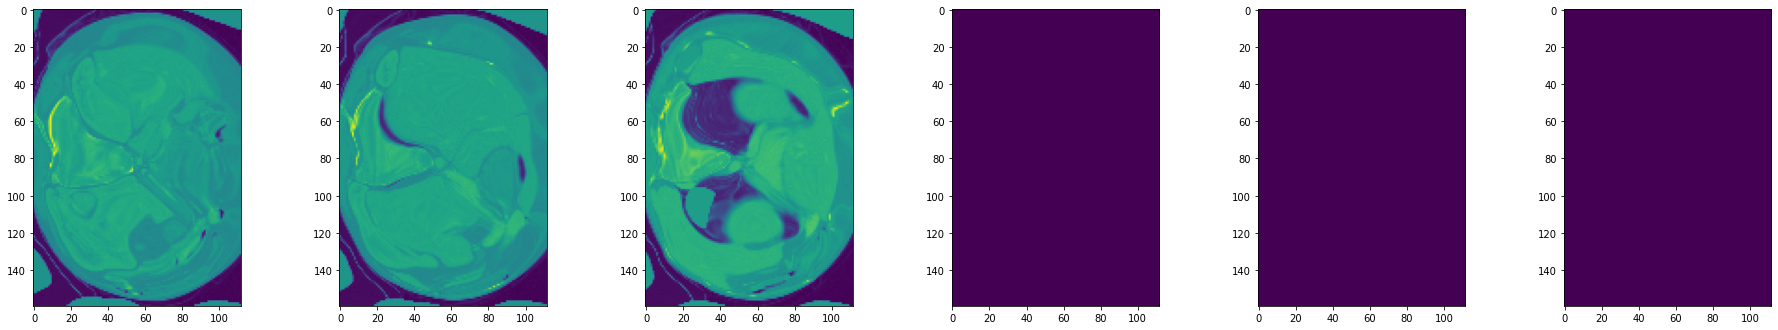

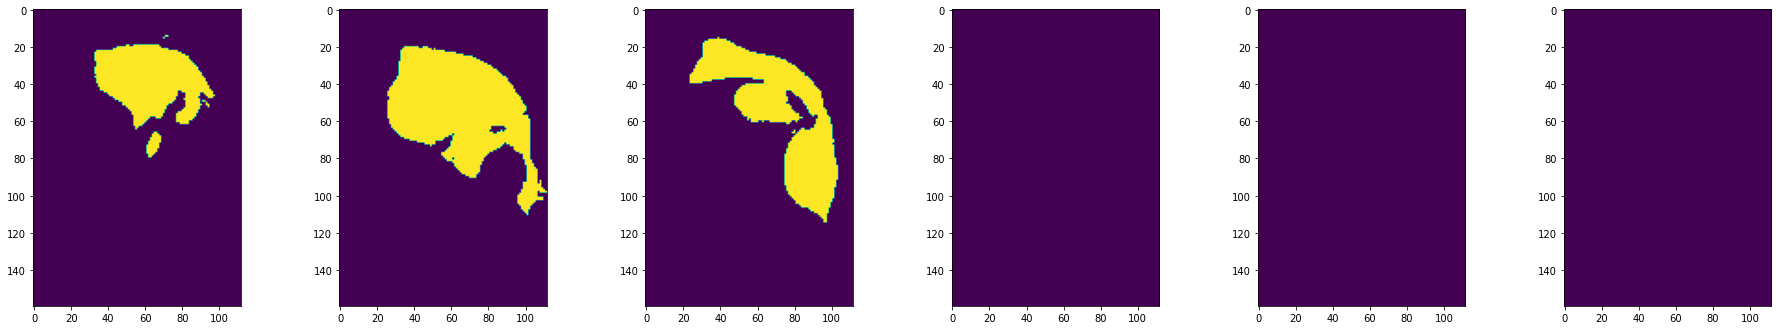

In [6]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))


print_slices(xtest)
print_slices(ytest)

In [7]:
# ---- entrainement ----

print("xtrain      : " + str(xtrain.shape))
print("ytrain      : " + str(ytrain.shape))
print("xvalidation : " + str(xvalidation.shape))
print("yvalidation : " + str(yvalidation.shape))

if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 1,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights(file_name)
else:
    model.load_weights(file_name)

xtrain      : (120, 96, 160, 112, 1)
ytrain      : (120, 96, 160, 112, 1)
xvalidation : (15, 96, 160, 112, 1)
yvalidation : (15, 96, 160, 112, 1)


In [8]:
prediction = model.predict(xtest)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv3d_16/Conv3D' defined at (most recent call last):
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\abarb\AppData\Local\Temp\ipykernel_25840\3057033249.py", line 1, in <cell line: 1>
      prediction = model.predict(xtest)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\abarb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv3d_16/Conv3D'
OOM when allocating tensor with shape[15,128,48,80,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv3d_16/Conv3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1660]

(897, 160, 112, 1)
(897, 160, 112, 1)


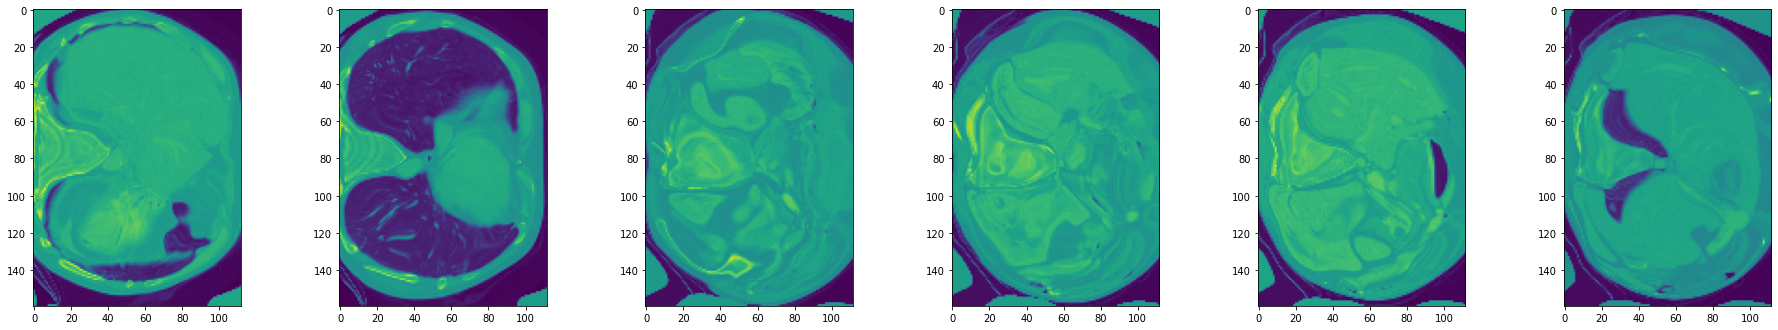

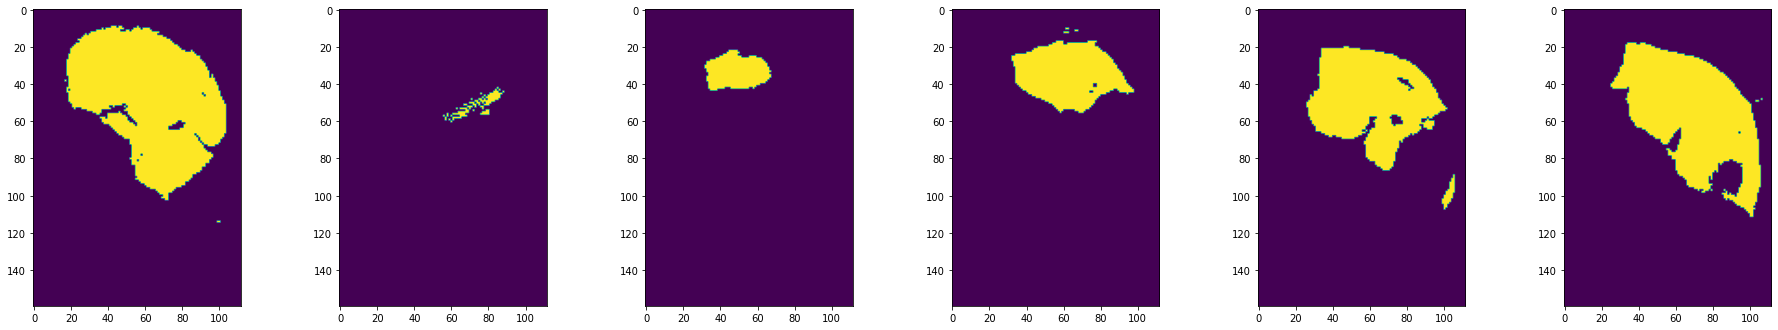

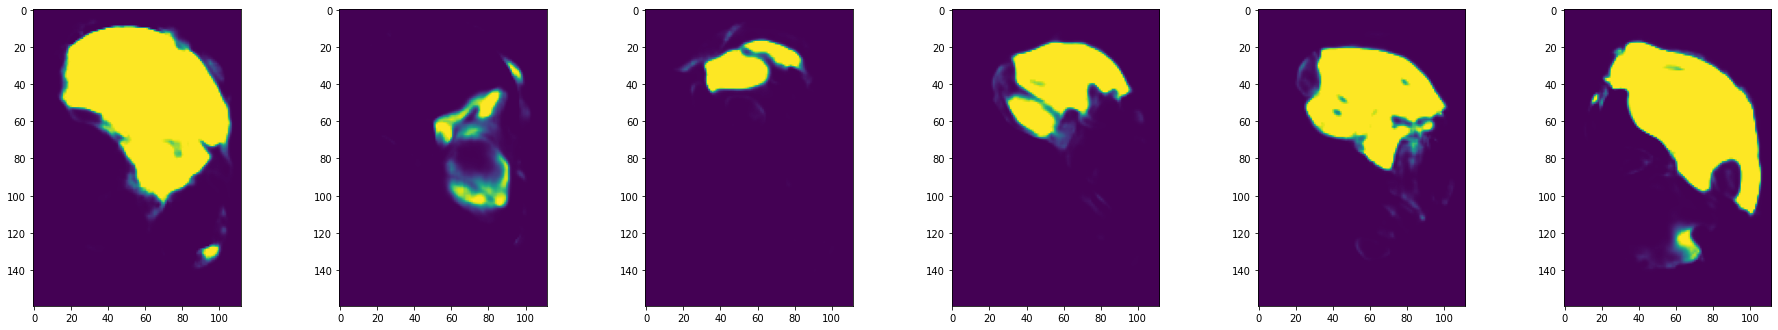

In [ ]:
print(xtest.shape)
print(ytest.shape)
print_slices(xtest)
print_slices(ytest)
print_slices(prediction)

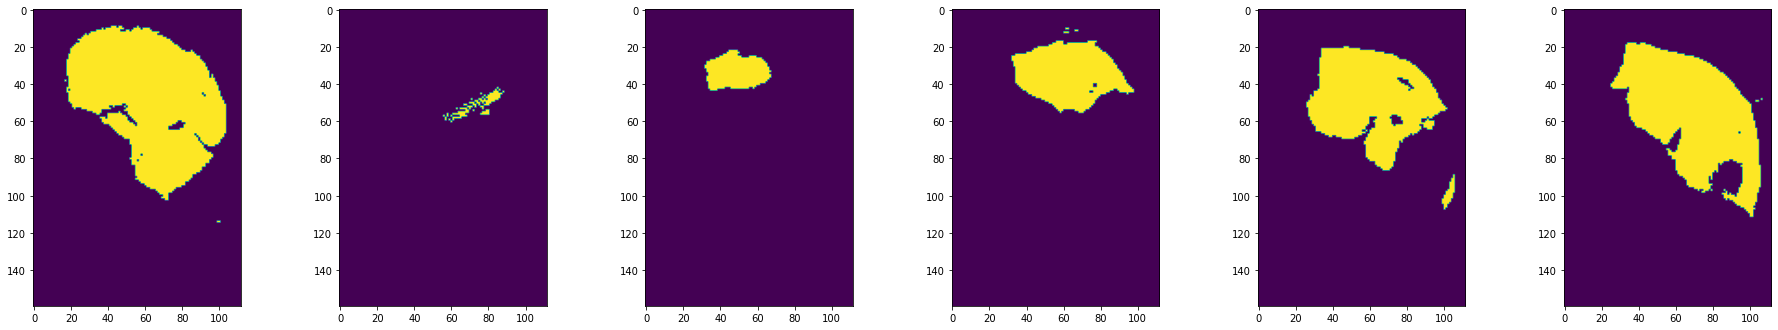

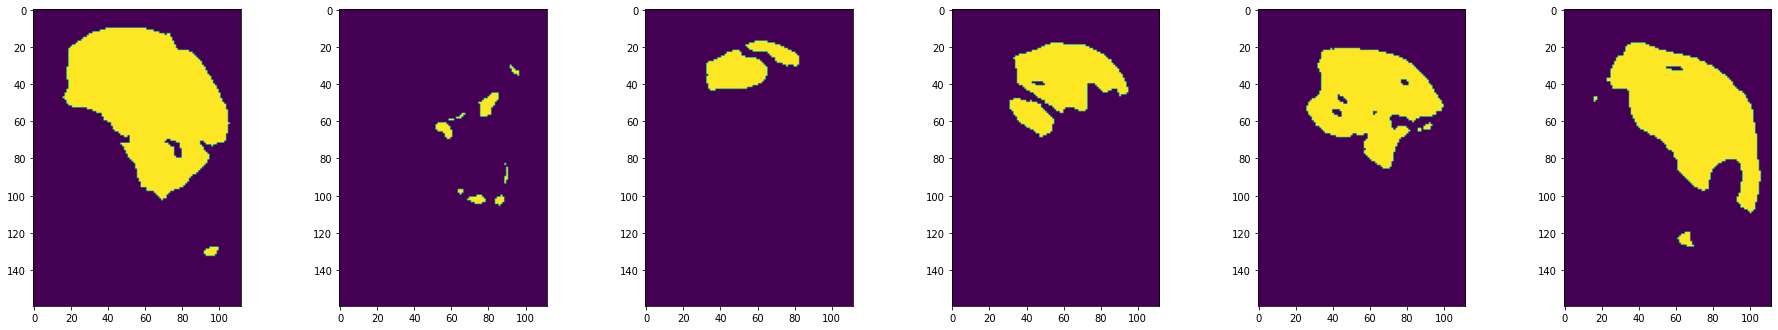

cardIntersec =  1106351
cardX =  1255647
cardY =  1338036
dice =  0.8531119647235225


In [ ]:
rounded_prediction = np.round(prediction)
print_slices(rounded_prediction)
dice = compute_dice(rounded_prediction, ytest)